## 1. Setup

### 1.0 Install and import dependencies

In [1]:
#@title Install and import dependencies
import math
import random, numpy as np, scipy, matplotlib.pyplot as plt, sklearn, librosa
import librosa.display
import IPython.display
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
import soundfile as sf
from pathlib import Path
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer

## 2. Data preprocessing

In [4]:
file_path = "/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master/audio-data/collins.mp3"
block_length = 1
# frame_length_s = 1
BPM = 167
beat = 1/8
frame_length_s = (4 * beat * 60 / BPM)
hop_length_s = frame_length_s * (1/8)

PLOT = 0

sr = librosa.get_samplerate(file_path)
frame_length = math.ceil(frame_length_s * sr)
hop_length = math.ceil(hop_length_s * sr)
stream = Streamer(file_path, block_length, frame_length, hop_length)

n_classes = 256 #@param {type: "integer"} only applies to kmeans

print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

Audio length: 200.46473922902496s, 8840495 samples
Sample rate: 44100 Hz
Frame length: 0.17964071856287425s,  7923 samples
Hop length: 0.02245508982035928s, 991 samples
Block length: 1 frame(s)
Number of blocks: 8921


In [15]:
######## TODO: Implement K-Fold validation

epochs = 3 #@param {type: "integer"} training epochs
batch_size = 64 #@param {type: "integer"} training batch size
maxlen = n_classes # length of the input sequence window
step = 2 #@param {type: "integer"} step size for the sliding window
hidden_units = 24 #@param {type: "integer"} number of hidden units in the GRU layer
callback = False #@param {type: "boolean"}
#@markdown ---
#@markdown **TODO:**\
#@markdown K-Fold validation settings:
k_fold_on = False #@param {type: "boolean"}
k = 2 #@param {type:"integer"}

SAVE = True #@param {type: "boolean"}
name = "collins" #@param {type:"string"}
directory = "/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master" #@param {type:"string"}

### 2.1 Extract features

In [5]:
def extract_features(y, sr):
    if y.size >= 2048:  
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False) # mfccs
    else:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
    m_mfccs = np.median(mfccs, axis=1)
    if m_mfccs.size == 0:
        print("Empty frame!")
    return m_mfccs

In [6]:
features = np.array([extract_features(block, sr) for block in stream.new()])
print(features.shape)
print(features[0])
features_scaled = preprocessing.scale(features, axis=1)
print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))
print(features_scaled[0]) # type: ignore

if PLOT:
  plt.scatter(features_scaled[:,0], features_scaled[:,1]) # type: ignore
  plt.xlabel('Zero Crossing Rate (scaled)')
  plt.ylabel('Spectral Centroid (scaled)')    

(8914, 13)
[-778.4691      43.99158     -1.9005668   21.148361    -3.6742253
   20.362595     4.7139635    9.4982815   -4.2551937   14.847035
   -4.094453     4.684469     2.1310823]
(8914, 13)
[-3.463465    0.24267164 -1.3618058  -0.12231935 -0.63363314  0.0305246
 -0.4533549  -0.23558849 -0.3930671  -0.32709035 -0.36328694 -0.2897519
 -0.18410175]
[-1.6654967   2.7403252   0.574674    1.6137736   0.3923718   0.8782767
  0.40747607  0.66568613  0.39641166  0.44889915  0.45511597  0.51620054
  0.4589949 ]
[-3.4573236   0.45476702  0.23647785  0.34611166  0.22804132  0.34237412
  0.2679403   0.29069725  0.22527789  0.31613898  0.22604248  0.26780003
  0.25565466]


/Users/wwerkowicz/miniconda/envs/cpu/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/wwerkowicz/miniconda/envs/cpu/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


### 2.2 Cluster

In [7]:
# frames = [frame for frame in frames if frame.size != 0] # remove empty
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)

n_labels = len(np.unique(labels))
print(f"Total labelled frames: {len(labels)}")
print(f"n_labels: {n_labels} (sanity check)")
labels = labels.tolist()

Total labelled frames: 8914
n_labels: 256 (sanity check)


In [8]:
frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
frames # sanity check

[[0, 7923],
 [991, 8914],
 [1982, 9905],
 [2973, 10896],
 [3964, 11887],
 [4955, 12878],
 [5946, 13869],
 [6937, 14860],
 [7928, 15851],
 [8919, 16842],
 [9910, 17833],
 [10901, 18824],
 [11892, 19815],
 [12883, 20806],
 [13874, 21797],
 [14865, 22788],
 [15856, 23779],
 [16847, 24770],
 [17838, 25761],
 [18829, 26752],
 [19820, 27743],
 [20811, 28734],
 [21802, 29725],
 [22793, 30716],
 [23784, 31707],
 [24775, 32698],
 [25766, 33689],
 [26757, 34680],
 [27748, 35671],
 [28739, 36662],
 [29730, 37653],
 [30721, 38644],
 [31712, 39635],
 [32703, 40626],
 [33694, 41617],
 [34685, 42608],
 [35676, 43599],
 [36667, 44590],
 [37658, 45581],
 [38649, 46572],
 [39640, 47563],
 [40631, 48554],
 [41622, 49545],
 [42613, 50536],
 [43604, 51527],
 [44595, 52518],
 [45586, 53509],
 [46577, 54500],
 [47568, 55491],
 [48559, 56482],
 [49550, 57473],
 [50541, 58464],
 [51532, 59455],
 [52523, 60446],
 [53514, 61437],
 [54505, 62428],
 [55496, 63419],
 [56487, 64410],
 [57478, 65401],
 [58469, 66392]

In [9]:
# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
print(len(labelled_frames[0])) # sanity check
print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

74
1810557 1818480


------------------
Label:  0
Random index: 38
3521023


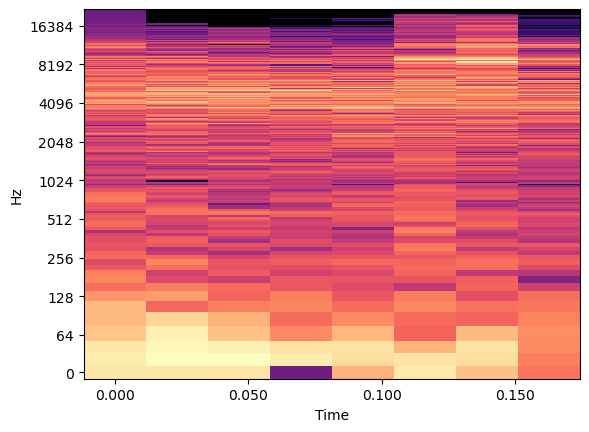

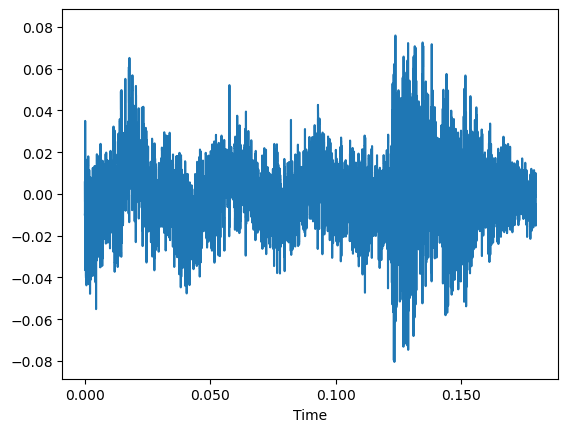

------------------
Label:  1
Random index: 40
1210011


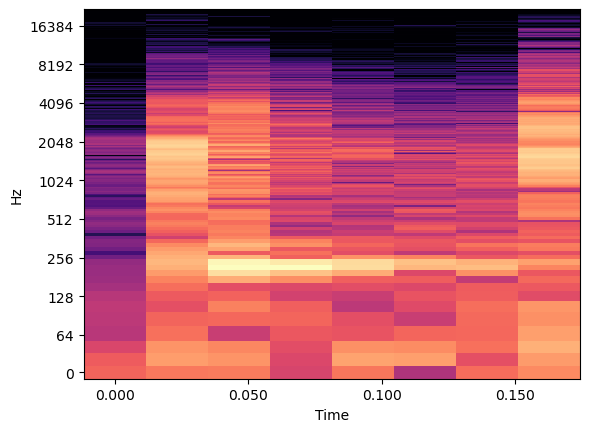

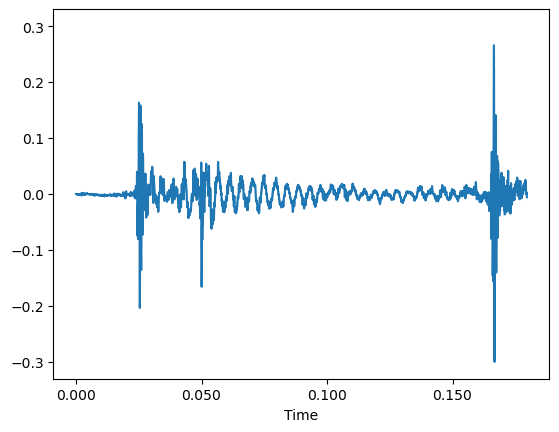

In [10]:
# preview cluster PLOTs
for i in range(PLOT):
    print("------------------")
    print("Label: ", i)
    f = stream.get_frame(dictionary=labelled_frames, label=i)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(f, hop_length=1024)),
                            ref=np.max) # type: ignore
    librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=1024,
                        x_axis='time')
    plt.show()
    librosa.display.waveshow(f, sr=sr) # display the waveform
    plt.show()
    display(IPython.display.Audio(f, rate=sr)) # play audio file using ipython display
    plt.show()

## 3. Training

### 3.1 One-hot encode data

In [16]:
#@title Train model
# One-hot encode
# build a subsequence for every <step> frames
# and a corresponding label that follows it
features = [] # these will be features
targets = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    features.append(labels[i: i + maxlen])
    targets.append(labels[i + maxlen])
# one-hot encode features and targets
# adapted from wandb character generation code referenced at the beginning of this notebook
encoded_features = np.zeros((len(features), maxlen, n_labels), dtype=bool)
encoded_targets = np.zeros((len(targets), n_labels), dtype=bool)
for i, sequence in enumerate(features):
    # print(i, sequence)
    for t, label in enumerate(sequence):
        encoded_features[i, t, label] = 1
        # print(encoded_features[i, t])
    encoded_targets[i, targets[i]] = 1
# sanity check
print(encoded_features.shape)
print(encoded_targets.shape)

(4329, 256, 256)
(4329, 256)


### 3.2 Build and compile

In [17]:
## optional - if training on GPU
# keras.mixed_precision.set_global_policy("mixed_float16")

# adapted from code by Lukas Biewald
# https://github.com/lukas/ml-class/blob/master/projects/7-text-generation/char-gen.py
inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units, return_sequences=True)(inputs)
# according to DLWP [13.2.1] softmax tends to be unstable in float16
outputs = Dense(n_labels, activation='softmax', dtype="float32")(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
model.compile(
    loss='sparse_categorical_crossentropy', # since we are using integer labels
    optimizer="rmsprop",
    metrics=['accuracy']
    )
model.summary()

Model: "collins"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256)]        0         
                                                                 
 gru_1 (GRU)                 (None, 256, 24)           20304     
                                                                 
 dense_1 (Dense)             (None, 256, 256)          6400      
                                                                 
Total params: 26,704
Trainable params: 26,704
Non-trainable params: 0
_________________________________________________________________


### 3.3 Train

In [18]:
model.fit(
      encoded_features,
      encoded_targets,
      batch_size=batch_size,
      epochs=epochs,

)

Epoch 1/3
68/68 [==============================] - 6s 79ms/step - loss: 2.8710 - accuracy: 0.9344
Epoch 2/3
68/68 [==============================] - 6s 82ms/step - loss: 0.2916 - accuracy: 0.9961
Epoch 3/3
68/68 [==============================] - 6s 81ms/step - loss: 0.0664 - accuracy: 0.9961


### 3.4 Save model

In [19]:
#@title (Optional) Save the audio frames and model
if SAVE:
  path = Path(directory + "/models/" + name)
  print(path)
  path.mkdir(exist_ok=True, parents=True)
  model_path = path / (name + ".keras")
  model.save(model_path)
  dict_path = path / (name + "_frames.json")
  dict_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
  # f_path = path / (name + "_features.json")
  # f_path.write_text(json.dumps(encoded_features, cls=NumpyEncoder))
  params = dict()
  params["filename"] = file_path.split('/')[-1]
  params["sr"] = sr
  params["BPM"] = BPM
  params["beat"] = beat
  params["n_classes"] = n_classes
  params["onset_detection"] = False
  params["hop_length"] = hop_length
  params["frame_length"] = frame_length
  params["block_length"] = block_length
  p_path = path / (name + "_config.json")    
  p_path.write_text(json.dumps(params))

/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master/models/collins
